<a href="https://colab.research.google.com/github/brscn2/deeplearning-for-coders-work/blob/main/ch5_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [ ]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_154.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_120.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_49.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_104.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_1.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_22.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_150.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_39.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_163.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_38.jpg')...]

In [ ]:
fname = (path/'images').ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['staffordshire_bull_terrier']

In [ ]:
## Presizing prevents data destruction (ie. corners empty when rotating, interpolation etc.)
## Presize the image to a larger size on CPU, then apply augmentations on GPU and RandomResizedCrop to resize it to the original size

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
# RandomResizedCrop is added since we included min_scale in our aug_transforms

dls = pets.dataloaders(path/'images')

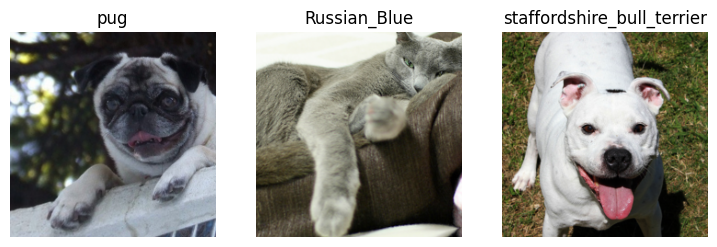

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.512862,0.382276,0.124493,01:12


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.497624,0.388812,0.121786,01:38
1,0.328654,0.262262,0.080514,01:15


In [ ]:
x,y = dls.one_batch()
y

TensorCategory([18, 14, 13,  1, 19, 10, 22,  8, 26, 36, 33, 19, 17,  0, 11, 32,
                31, 27,  7,  3, 36, 11,  9, 17, 22, 14, 28, 12,  9, 27,  0,  7,
                10, 27, 28, 10, 28,  9,  6, 25,  5, 10, 24,  0,  6,  6, 33,  5,
                24, 13, 31, 12,  8, 19, 19, 14, 28, 24,  4, 36, 31, 22, 34, 30],
               device='cuda:0')

In [ ]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([5.6446e-07, 1.4022e-05, 3.3549e-06, 6.6382e-05, 4.4023e-06, 2.2853e-05,
        3.7874e-07, 4.3517e-07, 2.2130e-07, 3.0341e-06, 3.3883e-07, 1.7261e-06,
        2.0022e-07, 4.0569e-05, 3.5619e-06, 1.0912e-06, 5.7611e-07, 3.7577e-06,
        9.9710e-01, 9.6463e-05, 1.0889e-05, 1.1252e-05, 2.0223e-05, 6.7135e-06,
        1.7158e-06, 1.8173e-06, 3.7765e-06, 1.4982e-03, 4.6309e-07, 1.3890e-07,
        4.4014e-07, 1.2445e-06, 1.0610e-03, 2.6246e-07, 6.9115e-06, 3.0664e-06,
        4.6945e-06])

In [ ]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

In [ ]:
# Taking exponential ensures that our numbers are positive
# Dividing by sum ensures that the numbers sum to 1
def softmax(x): return torch.exp(x) / torch.exp(x).sum(dim=1, keepdims=True)

In [ ]:
# By default, PyTorch takes the mean of the loss of all items.
# reduction='none' parameter disables that

loss_func = nn.CrossEntropyLoss()

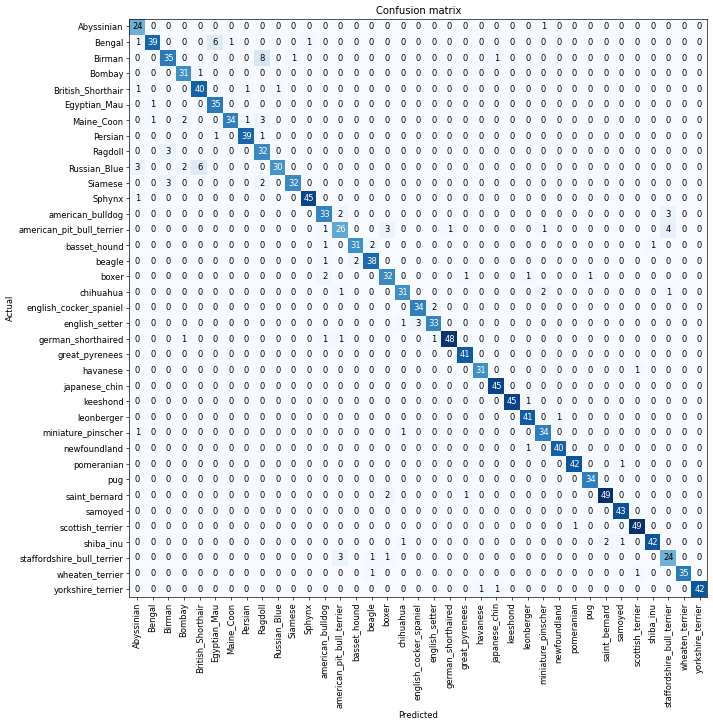

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[('Birman', 'Ragdoll', 8),
 ('Bengal', 'Egyptian_Mau', 6),
 ('Russian_Blue', 'British_Shorthair', 6)]

In [ ]:
# Improving the model
## Need to find a good learning rate
### Too high can cause overshoot of the minimum loss
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.799196,6.826885,0.539242,01:20


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,4.229568,3.258481,0.832206,01:32


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


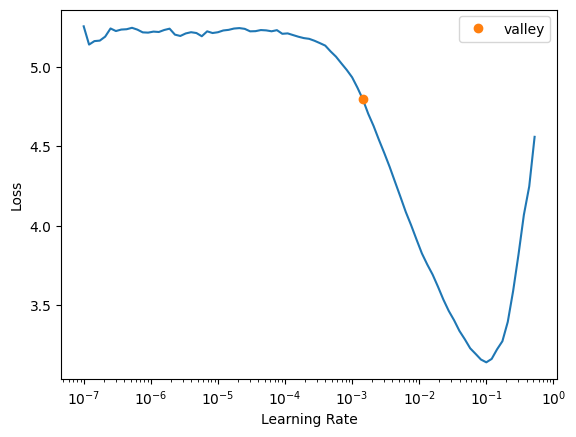

In [ ]:
# Use learning rate finder proposed by Leslie Smith, 2015
## The idea is to start with a truly small learning rate,
## increase it after each mini-batch until the loss starts to get worse
## at this point pick the last rate where the loss was clearly decreasing
learn = vision_learner(dls, resnet34, metrics=error_rate)
_ = learn.lr_find()

In [ ]:
# From the plot it seems that 3e^(-3) might be a good choice
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.284518,0.403364,0.124493,01:18


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.518071,0.445578,0.125169,01:15
1,0.314842,0.279745,0.082544,01:16


In [ ]:
## Fine-tuning the weights of the model
### The final layers are not useful for the task, since we are training on a different dataset
### Replace it with a new linear layer with the correct # of outputs (37 in this case)
### The earlier layers are kept since they recognize general concepts such as gradients, edges
### moreover eyeballs, fur and such.
### !Freeze the earlier layers!

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 145MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.152155,0.326079,0.106225,01:09
1,0.524835,0.288610,0.086604,01:08
2,0.329012,0.246759,0.084574,01:08


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
learn.unfreeze()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=7.585775892948732e-05)

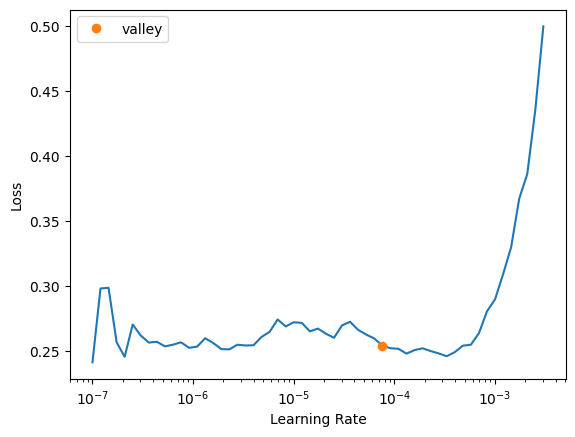

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.258134,0.246643,0.083897,01:12
1,0.265896,0.238113,0.081191,01:11
2,0.221944,0.232477,0.076455,01:43
3,0.197845,0.229023,0.077808,01:21
4,0.179863,0.228684,0.077131,01:15
5,0.184581,0.228227,0.076455,01:11


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# Discriminative Learning Rate
## Earlier layers do not need as high of a learning rate as the later ones
## Therefore use smaller learning rates for them and higher for the later layers.

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.159650,0.339275,0.094723,01:06
1,0.536140,0.247376,0.075101,01:05
2,0.299066,0.225119,0.070365,01:06


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.254310,0.223979,0.068336,01:11
1,0.249572,0.212051,0.069689,01:33
2,0.227554,0.213621,0.072395,01:16
3,0.203991,0.215741,0.067659,01:10
4,0.183264,0.207041,0.062923,01:11
5,0.166667,0.205039,0.065629,01:09
6,0.153382,0.203686,0.064276,01:10
7,0.132702,0.199682,0.062923,01:09
8,0.127876,0.198746,0.060893,01:10
9,0.130146,0.200503,0.061570,01:10


In [ ]:
# Using mixed-precision-training to speed up training
## Uses less-precision numbers when possible (to_fp16())

from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.146419,0.483815,0.154263,01:08
1,0.811051,0.378453,0.120433,01:06
2,0.532099,0.348939,0.108931,01:06


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.264960,0.288182,0.085927,01:09
1,0.246596,0.307125,0.094723,01:09
2,0.195766,0.259552,0.075778,01:08
3,0.141450,0.235041,0.071719,01:09
4,0.094764,0.216537,0.061570,01:08
5,0.071898,0.213279,0.058187,01:09
